In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

c:\Users\andre\anaconda3\envs\bsic\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Load Prices


In [3]:
path = "data/round_1"


def get_prices(round: int, day: int):

    path = f"data/round_{round}/prices_round_{round}_day_{day}.csv"

    return pd.read_csv(path, sep=";")


def get_trades(round: int, day: int):

    path = f"data/round_{round}/trades_round_{round}_day_{day}_nn.csv"

    return pd.read_csv(path, sep=";")

In [4]:
prices = get_prices(1, 0)
trades = get_trades(1, -1)

prices.head(2)

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,0,0,AMETHYSTS,9998,1,9995.0,30.0,NaN,NaN,10005,30,NaN,NaN,NaN,NaN,10001.5,0.0
1,0,0,STARFRUIT,5036,30,NaN,NaN,NaN,NaN,5043,30,NaN,NaN,NaN,NaN,5039.5,0.0


In [5]:
trades.head(2)

,timestamp,buyer,seller,symbol,currency,price,quantity
0,0,NaN,NaN,STARFRUIT,SEASHELLS,5047.0,13
1,0,NaN,NaN,STARFRUIT,SEASHELLS,5047.0,1


# Calculate MACD


Ideas

- Calculate MACD for bid/ask
- How to handle NaNs?
  - Fill with the better bid/ask for previous days and use the correct bid ask for that timestamp for bid/ask 2 and 3
- The current book in `order_depths` are the current orders outstanding that the bot can trade with

Things to do

- Check the current position of the bot and if the signal was long but he could not, then recompute the signal and go long as soon as possible
- How to choose the limit price for the order? Maybe always calculate MACDs for the worse bid/asks and determine a max fair value for the trade
- Check if some of the outstanding orders are from our bot


In [6]:
def calculate_MACD(
    data: pd.DataFrame,
    price_col: str,
    short_window: int,
    long_window: int,
    smoothing_window: int,
    min_periods: int,
):

    # Calculate the 12-period EMA

    ema_short = data[price_col].ewm(span=short_window, adjust=False).mean()

    ema_long = data[price_col].ewm(span=long_window, adjust=False).mean()

    macd = ema_short - ema_long

    signal = macd.ewm(span=smoothing_window, adjust=False).mean()

    macd.iloc[:min_periods] = np.nan

    signal.iloc[:min_periods] = np.nan

    return macd, signal, ema_short, ema_long

In [7]:
def plot_MACD(prices: pd.DataFrame, macd, signal, ema_short, ema_long):
    fig = plt.figure(figsize=(25, 10))

    gs = GridSpec(2, 1, height_ratios=[2, 1.5], figure=fig)

    price_ax = plt.subplot(gs[0])

    macd_ax = plt.subplot(gs[1])

    price_ax.plot(prices["timestamp"], prices["mid_price"])
    price_ax.plot(prices["timestamp"], ema_short, label="Short EMA", color="green")
    price_ax.plot(prices["timestamp"], ema_long, label="Long EMA", color="red")
    price_ax.legend()

    macd_ax.plot(macd, color="red", label="MACD")
    macd_ax.plot(signal, color="green", label="Signal")
    macd_ax.legend()

    plt.show()

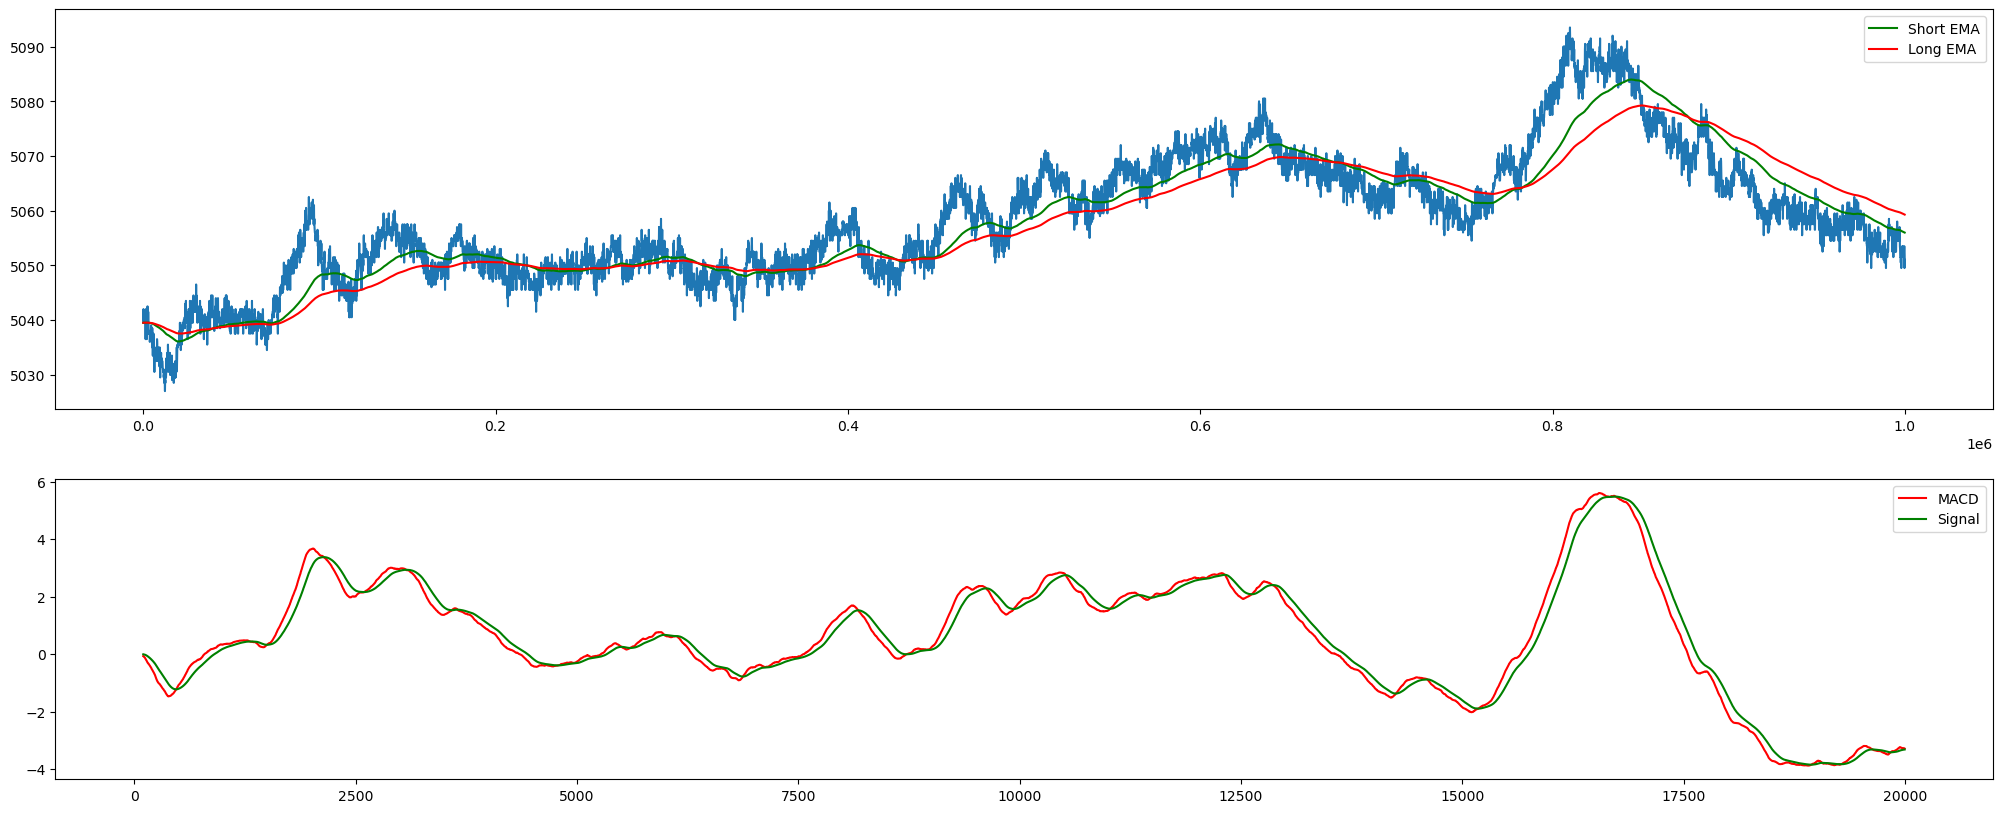

In [8]:
prices.sort_values(["product", "timestamp"], inplace=True)
starfruit = prices[prices["product"] == "STARFRUIT"].sort_values("timestamp")

SHORT_WINDOW = 500
LONG_WINDOW = 1000
SMOOTHING_WINDOW = 100

macd, signal, ema_short, ema_long = calculate_MACD(
    starfruit, "mid_price", SHORT_WINDOW, LONG_WINDOW, SMOOTHING_WINDOW, 50
)

plot_MACD(starfruit, macd, signal, ema_short, ema_long)

In [9]:
starfruit["long"] = signal > macd
starfruit["ret"] = starfruit["mid_price"].pct_change()
starfruit["long_ret"] = np.where(starfruit["long"].shift(1), starfruit["ret"] + 1, 1)

starfruit.tail(10)

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,long,ret,long_ret
19980,0,999000,STARFRUIT,5050,3,5049.0,27.0,NaN,NaN,5056,27,NaN,NaN,NaN,NaN,5053.0,0.0,False,0.000000,1.0
19982,0,999100,STARFRUIT,5049,2,5048.0,22.0,NaN,NaN,5055,24,NaN,NaN,NaN,NaN,5052.0,0.0,False,-0.000198,1.0
19984,0,999200,STARFRUIT,5049,25,NaN,NaN,NaN,NaN,5054,2,5055.0,1.0,5056.0,24.0,5051.5,0.0,False,-0.000099,1.0
19987,0,999300,STARFRUIT,5049,5,5048.0,26.0,NaN,NaN,5055,27,NaN,NaN,NaN,NaN,5052.0,0.0,False,0.000099,1.0
19988,0,999400,STARFRUIT,5048,26,NaN,NaN,NaN,NaN,5055,26,NaN,NaN,NaN,NaN,5051.5,0.0,False,-0.000099,1.0
19990,0,999500,STARFRUIT,5049,28,NaN,NaN,NaN,NaN,5056,28,NaN,NaN,NaN,NaN,5052.5,0.0,False,0.000198,1.0
19992,0,999600,STARFRUIT,5048,9,5047.0,27.0,NaN,NaN,5054,29,NaN,NaN,NaN,NaN,5051.0,0.0,False,-0.000297,1.0
19995,0,999700,STARFRUIT,5053,1,5048.0,26.0,NaN,NaN,5054,2,5055.0,24.0,NaN,NaN,5053.5,0.0,False,0.000495,1.0
19996,0,999800,STARFRUIT,5047,27,NaN,NaN,NaN,NaN,5052,1,5054.0,27.0,NaN,NaN,5049.5,0.0,False,-0.000792,1.0
19998,0,999900,STARFRUIT,5048,2,5047.0,21.0,NaN,NaN,5054,23,NaN,NaN,NaN,NaN,5051.0,0.0,False,0.000297,1.0


In [10]:
entry_points = starfruit["long"] != starfruit["long"].shift(1)
starfruit["is_entry_point"] = np.all(
    [starfruit["long"] == True, starfruit["long"].shift(1) == False], axis=0
)
starfruit["is_exit_point"] = np.all(
    [starfruit["long"] == False, starfruit["long"].shift(1) == True], axis=0
)
# exit_points = starfruit['long'] == True and starfruit['long'] != starfruit['long'].shift(1)

starfruit.tail(10)

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,...,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,long,ret,long_ret,is_entry_point,is_exit_point
19980,0,999000,STARFRUIT,5050,3,5049.0,27.0,NaN,NaN,5056,...,NaN,NaN,NaN,5053.0,0.0,False,0.000000,1.0,False,False
19982,0,999100,STARFRUIT,5049,2,5048.0,22.0,NaN,NaN,5055,...,NaN,NaN,NaN,5052.0,0.0,False,-0.000198,1.0,False,False
19984,0,999200,STARFRUIT,5049,25,NaN,NaN,NaN,NaN,5054,...,1.0,5056.0,24.0,5051.5,0.0,False,-0.000099,1.0,False,False
19987,0,999300,STARFRUIT,5049,5,5048.0,26.0,NaN,NaN,5055,...,NaN,NaN,NaN,5052.0,0.0,False,0.000099,1.0,False,False
19988,0,999400,STARFRUIT,5048,26,NaN,NaN,NaN,NaN,5055,...,NaN,NaN,NaN,5051.5,0.0,False,-0.000099,1.0,False,False
19990,0,999500,STARFRUIT,5049,28,NaN,NaN,NaN,NaN,5056,...,NaN,NaN,NaN,5052.5,0.0,False,0.000198,1.0,False,False
19992,0,999600,STARFRUIT,5048,9,5047.0,27.0,NaN,NaN,5054,...,NaN,NaN,NaN,5051.0,0.0,False,-0.000297,1.0,False,False
19995,0,999700,STARFRUIT,5053,1,5048.0,26.0,NaN,NaN,5054,...,24.0,NaN,NaN,5053.5,0.0,False,0.000495,1.0,False,False
19996,0,999800,STARFRUIT,5047,27,NaN,NaN,NaN,NaN,5052,...,27.0,NaN,NaN,5049.5,0.0,False,-0.000792,1.0,False,False
19998,0,999900,STARFRUIT,5048,2,5047.0,21.0,NaN,NaN,5054,...,NaN,NaN,NaN,5051.0,0.0,False,0.000297,1.0,False,False


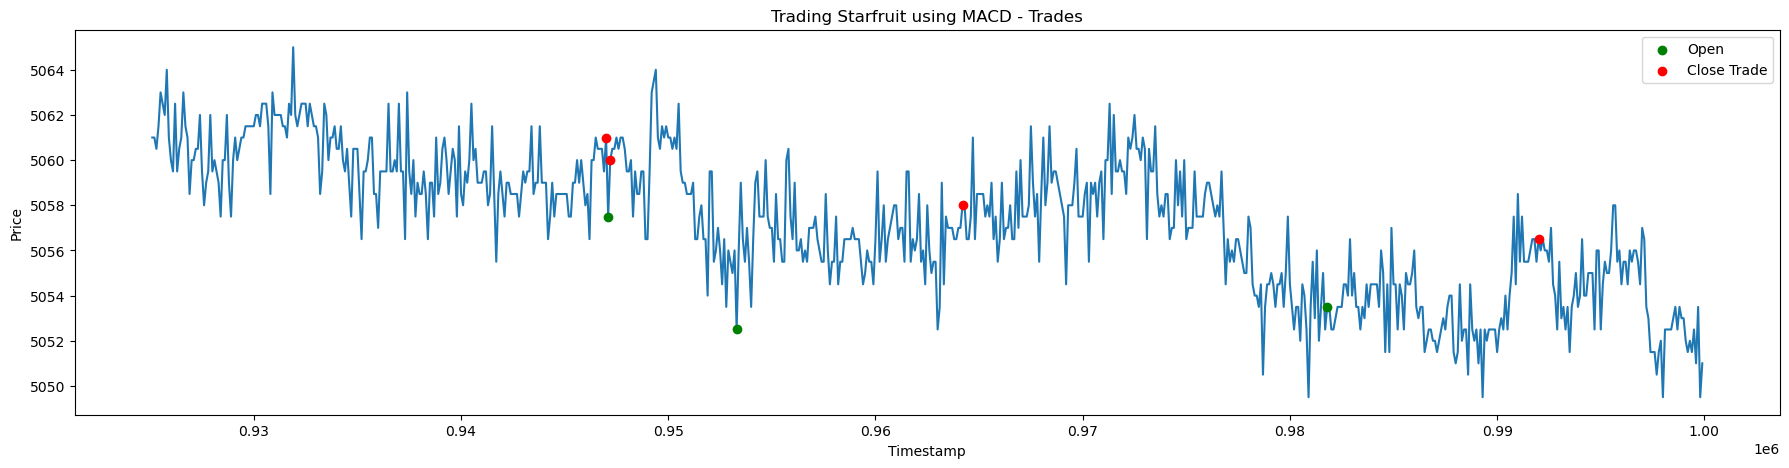

In [11]:
def plot_trades(data: pd.DataFrame, from_timestamp: int):
    fig, ax = plt.subplots(figsize=(22, 5))

    data = data[data["timestamp"] > from_timestamp].copy()

    ax.plot(data["timestamp"], data["mid_price"])

    entries = data[data["is_entry_point"]]
    exits = data[data["is_exit_point"]]

    for i, trade_series in enumerate([entries, exits]):
        color = "green" if i == 0 else "red"
        label = "Open" if i == 0 else "Close" + " Trade"
        ax.scatter(
            trade_series["timestamp"],
            trade_series["mid_price"],
            color=color,
            label=label,
            zorder=i + 2,
        )

    ax.legend()
    ax.set_title("Trading Starfruit using MACD - Trades")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Price")


plot_trades(starfruit, 9.25e5)

Text(0, 0.5, 'Equity')

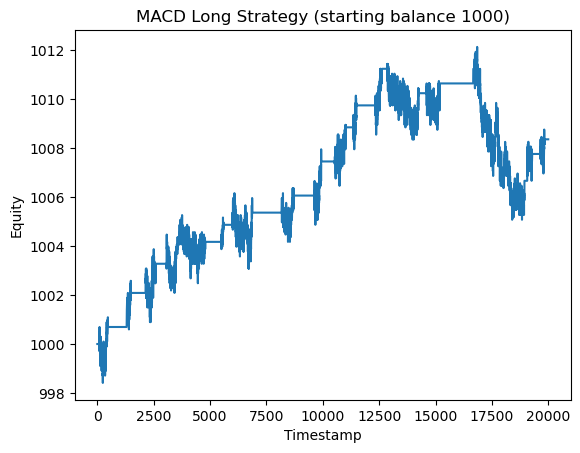

In [12]:
bal = 1000 * starfruit["long_ret"].cumprod()

plt.plot(bal)
plt.title("MACD Long Strategy (starting balance 1000)")
plt.xlabel("Timestamp")
plt.ylabel("Equity")

In [13]:
(
    (starfruit["ask_price_1"] - starfruit["bid_price_1"]) / starfruit["mid_price"]
).mean() * 100

0.10761373521664622

In [14]:
amethysts = prices[prices["product"] == "AMETHYSTS"].sort_values("timestamp")

(
    (amethysts["ask_price_1"] - amethysts["bid_price_1"]) / amethysts["mid_price"]
).mean() * 100

0.06776699788566183

In [15]:
starfruit["long_ret"].mean() - 1

8.602201773122431e-07

In [16]:
starfruit["mid_price"].rolling(100).var()

1             NaN
3             NaN
5             NaN
6             NaN
9             NaN
           ...   
19990    3.527374
19992    3.602298
19995    3.577652
19996    3.772197
19998    3.846061
Name: mid_price, Length: 10000, dtype: float64

# Updating DF with the new data


In [17]:
data = [{"price": 10, "product": "SEASHELLS"}, {"price": 11, "product": "SEASHELLS"}]
df = pd.DataFrame.from_records(data)

df

,price,product
0,10,SEASHELLS
1,11,SEASHELLS


# Stoikov Model


Parameters for **Reserve Price**

$$\text{Reserve Price} = s - q\cdot \gamma \cdot\sigma^2\cdot (T-t)$$

- $q$: how distant the trader's current inventory is from the target position? $q$ indicates the difference between current and desired inventory. In our case we want to be long/short based on trend.
- $\gamma$: inventory risk the MM is willing to take
- $T-t$: time until the end of the trading session. T is usually normalized to 1, in our case t will be = timestamp / total number of ticks in a trading session.
- $\sigma$: market volatility. If the market volatility incresaes, the distance between the reservation price and market mid-price will also increase

Units:

- $\sigma$: dollars per unit time $dt$
- $\delta$ is in dollars too
- $k$ is mapping the distance to the fair price to a quantity without unit, so it is in $1/dollars$
- $\gamma$ is a risk aversion parameter. Difficult to choose, trials and errors can help.

<p align='center'>Optimal Spread</p>

$$\delta^a+\delta^b=\gamma \cdot \sigma^2(T-t) + \frac{2}{\gamma}ln(1+\frac{\gamma}{k})$$

Two of the factors are incorporated from the reservation price formula ($\gamma $ and $(T-t)$) and a new factor is incorporated:

- $k$ - Order book Liquidity/Density: look at ways to calculate it. If k is significant, we are assuming the order book is denser and we need to have more competitive spreads. If the order book is less competitive we can have wider spreads

**Combining the Two**

$$\text{Ask/Bid} = \text{Res Price} \pm \frac{\text{Optimal Spread}}{2}$$

### Estimating k

$k$ parameter models order book liquidity, with larger values corresponding to higher trading intensity. For a given time interval $\pi_n=t_n-t_{n-1}$, $k$ can be estimated as

$$k_n^a=\frac{\lambda_n^a\cdot\lambda^a_{n-1}}{\lambda_n^a-\lambda^a_{n-1}}$$

Where lambdas are the orderbook update arrival rates on the ask and bid sides, in the time interval $\pi_n$. "Note that this approach allows us to estimate the k parameters simply by coutning the orders arrivals at each time interval $\pi_n$" => **estimate $\lambda_n^a$ as number of bid/asks in time $n$?**


In [18]:
orders_t = 8
orders_t_1 = 10

(orders_t * orders_t_1) / (orders_t - orders_t_1)

-40.0

In [19]:
def stoikov_model_res_price(s, q, gamma, sigma, T, t):
    return s - q * gamma * sigma**2 * (T - t)


def stoikov_model_spread(gamma, sigma, T, t, k):
    return gamma * sigma**2 * (T - t) + 2 / gamma * np.log(1 + gamma / k)

In [20]:
# testing
GAMMA = 0.01
K = 0.5

SIGMA = np.sqrt(3.8)
T = 1
t = 0
S = 5039.5  # current midprice

CURRENT_POS = -20
TARGET_POS = 20
Q = CURRENT_POS - TARGET_POS

r = stoikov_model_res_price(S, Q, GAMMA, SIGMA, T, t)
spread_sum = stoikov_model_spread(GAMMA, SIGMA, T, t, K)

print(r)  # 98 makes sense since we want to
print(spread_sum)


def get_bid_ask(res_price, spread):
    return res_price - spread / 2, res_price + spread / 2


bid, ask = get_bid_ask(r, spread_sum)
print(f"\ncurrent midprice is {S}, refprice is {r}")
print(f"bid: {bid:.2f}, ask: {ask:.2f}, spread: {ask - bid:.2f}")

5041.02
3.9985254592359456

current midprice is 5039.5, refprice is 5041.02
bid: 5039.02, ask: 5043.02, spread: 4.00


## Fixing Imbalance


In [21]:
matrix = np.array([[1, 2, 3], [1, np.nan, 3], [np.nan, 1, 2]])
matrix

array([[ 1.,  2.,  3.],
       [ 1., nan,  3.],
       [nan,  1.,  2.]])

In [22]:
bid1 = np.array([1, np.nan, np.nan])
volb1 = np.array([1, np.nan, np.nan])
ask1 = np.array([1, 2, 3])
vola1 = np.array([1, 2, 3])

np.vstack([bid1, vola1, ask1, volb1]).T

array([[ 1.,  1.,  1.,  1.],
       [nan,  2.,  2., nan],
       [nan,  3.,  3., nan]])

In [23]:
np.any(np.isnan(matrix), axis=1).reshape(-1, 1)

array([[False],
       [ True],
       [ True]])

In [24]:
prices.iloc[50]


def vw_mid_price(data):
    # S = Pa * Vb / (Va + Vb) + Pb * Va / (Va + Vb)
    bid_amt = data["bid_size_1"] + data["bid_size_2"] + data["bid_size_3"]
    ask_amt = data["ask_size_1"] + data["ask_size_2"] + data["ask_size_3"]
    tot_amt = bid_amt + ask_amt

    pa1 = data["ask_price_1"]
    pa2 = data["ask_price_2"]
    pa3 = data["ask_price_3"]
    pb1 = data["bid_price_1"]
    pb2 = data["bid_price_2"]
    pb3 = data["bid_price_3"]
    sa1 = data["ask_size_1"]
    sa2 = data["ask_size_2"]
    sa3 = data["ask_size_3"]
    sb1 = data["bid_size_1"]
    sb2 = data["bid_size_2"]
    sb3 = data["bid_size_3"]

    m1 = (pa1 * sb1) / (sa1 + sb1) + (pb1 * sa1) / (sa1 + sb1)
    m2 = (pa2 * sb2) / (sa2 + sb2) + (pb2 * sa2) / (sa2 + sb2)
    m3 = (pa3 * sb3) / (sa3 + sb3) + (pb3 * sa3) / (sa3 + sb3)
    print(f"m1: {m1}, m2: {m2}, m3: {m3}")
    mids = np.array([m1, m2, m3])
    mids[np.isnan(mids)] = 0
    vols = np.array([sa1 + sb1, sa2 + sb2, sa3 + sb3])
    return sum(mids * vols / sum(vols))
    return sum([m1, m2, m3]) / 3

    # S = ( Pa1 * Vb1 + Pa2 * Vb2 ... ) / total volum
    s = (pa1 * sb1 + pa2 * sb2 + pa3 * sb3) / tot_amt + (
        pb1 * sa1 + pb2 * sa2 + pb3 * sa3
    ) / tot_amt
    return s


def vw_mid_price_vectorized(data):
    bid_sizes = np.abs(np.array([data[f"bid_volume_{i+1}"] for i in range(3)]))
    ask_sizes = np.abs(np.array([data[f"ask_volume_{i+1}"] for i in range(3)]))
    bid_prices = np.abs(np.array([data[f"bid_price_{i+1}"] for i in range(3)]))
    ask_prices = np.abs(np.array([data[f"ask_price_{i+1}"] for i in range(3)]))

    stacked = np.vstack([bid_sizes, ask_sizes, bid_prices, ask_prices]).T
    mask = ~np.any(np.isnan(stacked), axis=1)

    print(mask)

    mids = (ask_prices[mask] * bid_sizes[mask]) / (
        ask_sizes[mask] + bid_sizes[mask]
    ) + (bid_prices[mask] * ask_sizes[mask]) / (ask_sizes[mask] + bid_sizes[mask])
    # mids = np.nan_to_num(mids)
    vols = ask_sizes[mask] + bid_sizes[mask]

    print(f"vols: \n{ask_sizes[mask]}, \n{bid_sizes[mask]}")
    print(f"data: \n{stacked}")

    print(mids, vols)

    s = np.sum(mids * vols) / np.sum(vols)

    return s

In [25]:
data = {
    "timestamp": 0,
    "ask_volume_1": 22,
    "ask_volume_2": np.nan,
    "ask_volume_3": np.nan,
    "bid_volume_1": 7,
    "bid_volume_2": 22,
    "bid_volume_3": np.nan,
    "ask_price_1": 5042,
    "ask_price_2": np.nan,
    "ask_price_3": np.nan,
    "bid_price_1": 5036,
    "bid_price_2": 5035,
    "bid_price_3": np.nan,
    "mid_price": 5039.5,
    "spread": 0.0013890266891556703,
}

mid = vw_mid_price_vectorized(data)
mid

[ True False False]
vols: 
[22.], 
[7.]
data: 
[[   7.   22. 5036. 5042.]
 [  22.   nan 5035.   nan]
 [  nan   nan   nan   nan]]
[5037.44827586] [29.]


5037.448275862069

In [26]:
def old_mid_price_adj(data):
    data = {i: data[i] if not np.isnan(data[i]) else 0 for i in data}

    bid_amt = data["bid_volume_1"] + data["bid_volume_2"] + data["bid_volume_3"]
    ask_amt = data["ask_volume_1"] + data["ask_volume_2"] + data["ask_volume_3"]
    tot_amt = (
        data["bid_volume_1"]
        + data["bid_volume_2"]
        + data["bid_volume_3"]
        + data["ask_volume_1"]
        + data["ask_volume_2"]
        + data["ask_volume_3"]
    )

    vw_bid = (
        data["bid_price_1"] * data["bid_volume_1"]
        + data["bid_price_2"] * data["bid_volume_2"]
        + data["bid_price_3"] * data["bid_volume_3"]
    ) / bid_amt
    vw_ask = (
        data["ask_price_1"] * data["ask_volume_1"]
        + data["ask_price_2"] * data["ask_volume_2"]
        + data["ask_price_3"] * data["ask_volume_3"]
    ) / ask_amt

    s = vw_ask * bid_amt / tot_amt + vw_bid * ask_amt / tot_amt

    print(f"vw_bid: {vw_bid}, vw_ask: {vw_ask}")

    return s


mid_old = old_mid_price_adj(data)
mid_old

vw_bid: 5035.241379310345, vw_ask: 5042.0


5039.084516565246

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def plot_orderbook(data, mid, mid_old):
    # your original data
    ask_price = [
        data[f"ask_price_{i}"] if not np.isnan(data["ask_price_1"]) else 0
        for i in range(1, 4)
    ]
    ask_qty = [
        data[f"ask_volume_{i}"] if not np.isnan(data["ask_volume_1"]) else 0
        for i in range(1, 4)
    ]
    bid_price = [
        data[f"bid_price_{i}"] if not np.isnan(data["bid_price_1"]) else 0
        for i in range(1, 4)
    ]
    bid_qty = [
        data[f"bid_volume_{i}"] if not np.isnan(data["bid_volume_1"]) else 0
        for i in range(1, 4)
    ]

    ask_df = pd.DataFrame({"price": ask_price, "quantity": ask_qty})
    bid_df = pd.DataFrame({"price": bid_price, "quantity": bid_qty})

    fig, ax = plt.subplots()
    ax.set_title(f"Order Book Depth Chart")
    sns.ecdfplot(
        x="price", weights="quantity", stat="count", data=ask_df, ax=ax, color="red"
    )
    sns.ecdfplot(
        x="price",
        weights="quantity",
        stat="count",
        complementary=True,
        data=bid_df,
        ax=ax,
        color="green",
    )
    # complementary=True allows reflects that lower bids are "better"
    ax.set_xlabel("Price")
    ax.set_ylabel("Quantity")

    ax.vlines(mid, 0, 30, color="blue", label="Mid Price")
    ax.vlines(mid_old, 0, 30, color="black", label="Mid Price (old)")

    ax.legend()

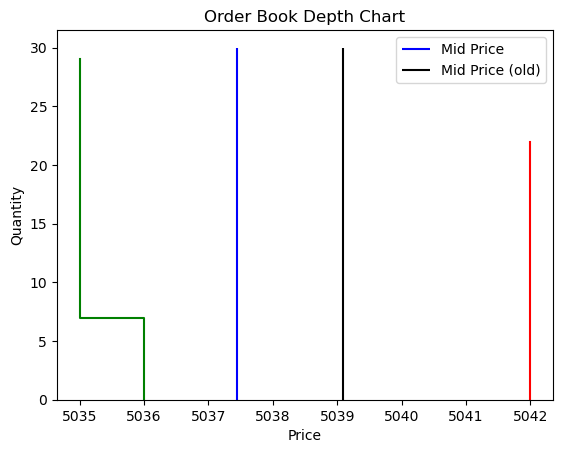

In [28]:
plot_orderbook(data, mid, mid_old)

# Amethysts


In [30]:
amethysts = prices[prices["product"] == "AMETHYSTS"].sort_values("timestamp")

amethysts.head()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,0,0,AMETHYSTS,9998,1,9995.0,30.0,NaN,NaN,10005,30,NaN,NaN,NaN,NaN,10001.5,0.0
2,0,100,AMETHYSTS,9996,1,9995.0,30.0,NaN,NaN,10002,6,10004.0,1.0,10005.0,30.0,9999.0,0.0
4,0,200,AMETHYSTS,9996,1,9995.0,21.0,NaN,NaN,10004,1,10005.0,21.0,NaN,NaN,10000.0,0.0
7,0,300,AMETHYSTS,9996,2,9995.0,23.0,NaN,NaN,9998,3,10004.0,2.0,10005.0,23.0,9997.0,0.0
8,0,400,AMETHYSTS,9998,5,9996.0,2.0,9995.0,23.0,10004,2,10005.0,23.0,NaN,NaN,10001.0,0.0


In [34]:
amethysts["mid_price"].rolling(50).var().mean()

2.2402965654304166

In [53]:
# testing
GAMMA = 0.025
K = 0.25

SIGMA = np.sqrt(2.24)
T = 1
t = 0
S = 10_000  # current midprice

CURRENT_POS = -20
TARGET_POS = 0
Q = CURRENT_POS - TARGET_POS

r = stoikov_model_res_price(S, Q, GAMMA, SIGMA, T, t)
spread_sum = stoikov_model_spread(GAMMA, SIGMA, T, t, K)

print(r)  # 98 makes sense since we want to
print(spread_sum)


def get_bid_ask(res_price, spread):
    return res_price - spread / 2, res_price + spread / 2


bid, ask = get_bid_ask(r, spread_sum)
print(f"\ncurrent midprice is {S}, refprice is {r}")
print(f"bid: {bid:.2f}, ask: {ask:.2f}, spread: {ask - bid:.2f}")

10001.12
7.680814384345995

current midprice is 10000, refprice is 10001.12
bid: 9997.28, ask: 10004.96, spread: 7.68
